# Generate permutations

In [1]:
import itertools
import random
import numpy as np
from scipy.spatial.distance import hamming


# Build list of all possible permutations
random.seed(42)
permuts_list = list(itertools.permutations(range(9)))
permuts_array = np.array(permuts_list)
no_permuts = len(permuts_list)


# Take top x permutations which have max average hamming distance
permuts_to_take = 1000
set_of_taken = set()
cnt_iterations = 0
while True:
    cnt_iterations += 1
    x = random.randint(1, no_permuts - 1)
    y = random.randint(1, no_permuts - 1)
    permut_1 = permuts_array[x]
    permut_2 = permuts_array[y]
    hd = hamming(permut_1, permut_2)

    if hd > 0.9 and (not x in set_of_taken) and (not y in set_of_taken):
        set_of_taken.add(x)
        set_of_taken.add(y)

        if len(set_of_taken) == permuts_to_take:
            break
        
print ("No of iterations it took to build top - {} permutations array = {}".format(permuts_to_take, cnt_iterations))
print ("No of permutations", len(set_of_taken))

No of iterations it took to build top - 1000 permutations array = 1411
No of permutations 1000


In [ ]:
# Build the array for selected permutation indices above
selected_permuts = []
for ind, perm_id in enumerate(set_of_taken):
    if ind < 10:
        print ("Sample permutation {}".format(ind))
        print (permuts_array[perm_id])
    selected_permuts.append(permuts_array[perm_id])

selected_permuts = np.array(selected_permuts)
np.save('selected_permuts.npy', selected_permuts)


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms


def_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

hflip_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

darkness_jitter_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(brightness=[0.5, 0.9]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

lightness_jitter_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(brightness=[1.1, 1.5]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

rotations_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

all_in_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


def crop_from_center(pil_image, new_h, new_w):

    width, height = pil_image.size  # Get dimensions

    left = (width - new_w) / 2
    top = (height - new_h) / 2
    right = (width + new_w) / 2
    bottom = (height + new_h) / 2

    # Crop the center of the image
    pil_image = pil_image.crop((left, top, right, bottom))

    return pil_image


def get_nine_crops(pil_image):
    """
    Get nine crops for a square pillow image. That is height and width of the image should be same.
    :param pil_image: pillow image
    :return: List of pillow images. The nine crops
    """
    w, h = pil_image.size
    diff = int(w/3)

    r_vals = [0, diff, 2 * diff]
    c_vals = [0, diff, 2 * diff]

    list_patches = []

    for r in r_vals:
        for c in c_vals:

            left = c
            top = r
            right = c + diff
            bottom = r + diff

            patch = pil_image.crop((left, top, right, bottom))
            list_patches.append(patch)

    return list_patches


def split_train_into_train_val(train_file_ids, train_file_paths, train_labels, test_size=0.1):
    """
    Split train_file_paths and train_labels to train_file_paths, val_file_paths and
    train_labels, val_labels
    """

    # Create a mapping between image_id and file_path
    image_id_name_map = dict(zip(train_file_ids, train_file_paths))

    # Get validation files and validation labels separate
    train_file_ids, val_file_ids, train_labels, val_labels = train_test_split(
        train_file_ids, train_labels, test_size=test_size, random_state=5, shuffle=True
    )
    train_file_paths = [image_id_name_map[image_id] for image_id in train_file_ids]
    val_file_paths = [image_id_name_map[image_id] for image_id in val_file_ids]

    print ("Length of train files list", len(train_file_paths))
    print ("Length of train labels", len(train_labels))
    print ("Length of val files list", len(val_file_paths))
    print ("Length of val labels", len(val_labels))

    return train_file_ids, val_file_ids, train_file_paths, val_file_paths, train_labels, val_labels

def get_paths():
    data_dir = '/home/raj/GNR-650/Assignment_3/CIFAR-10-images/train'
    file_paths_to_return = []
    
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".jpg"):
                file_paths_to_return.append(root+'/'+file)                        
    
    return file_paths_to_return

def get_train_test_file_paths_n_labels():
    """
    Get array train_file_paths, train_labels, test_file_paths and test_labels
    """

    # Data loading and data generators set up
    #par_data_dir = 'train'
    images_data_dir = 'train'
    train_test_split_file = 'train_test_split.txt'
    images_file = 'images.txt'
    labels_file = 'image_class_labels.txt'

    # Read the images_file which stores image-id and image-name mapping
    image_file_id_df = pd.read_csv(images_file, sep=' ', header=None)
    image_file_id_mat = image_file_id_df.values
    image_id_name_map = dict(zip(image_file_id_mat[:, 0], image_file_id_mat[:, 1]))

    # Read the train_test_split file which stores image-id and train-test split mapping
    image_id_train_test_split_df = pd.read_csv(train_test_split_file, sep=' ', header=None)
    image_id_train_test_split_mat = image_id_train_test_split_df.values
    image_id_train_test_split_map = dict(zip(image_id_train_test_split_mat[:, 0],
                                             image_id_train_test_split_mat[:, 1]))

    # Read the image class labels file
    image_id_label_df = pd.read_csv(labels_file, sep=' ', header=None)
    image_id_label_mat = image_id_label_df.values
    image_id_label_map = dict(zip(image_id_label_mat[:, 0], image_id_label_mat[:, 1]))

    # Put together train_files train_labels test_files and test_labels lists
    train_image_ids, test_image_ids = [], []
    train_file_paths, test_file_paths = [], []
    train_labels, test_labels = [], []
    for file_id in image_id_name_map.keys():
        file_name = image_id_name_map[file_id]
        is_train = image_id_train_test_split_map[file_id]
        label = image_id_label_map[file_id] - 1  # To ensure labels start from 0

        if is_train:
            train_image_ids.append(file_id)
            train_file_paths.append(os.path.join(images_data_dir, file_name))
            train_labels.append(label)
        else:
            test_image_ids.append(file_id)
            test_file_paths.append(os.path.join(images_data_dir, file_name))
            test_labels.append(label)

    print ("Length of train files list", len(train_file_paths))
    print ("Length of train labels list", len(train_labels))
    print ("Length of test files list", len(test_file_paths))
    print ("Length of test labels list", len(test_labels))

    return train_image_ids, test_image_ids, train_file_paths, test_file_paths, train_labels, test_labels



# Generate Jigsaw from permutations

In [3]:
import json
import numpy as np
import random

import torch
from PIL import Image
from torch.utils.data import Dataset

#from dataset_helpers import crop_from_center, get_nine_crops


class GetDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_paths, labels, transform=None):
        'Initialization'
        self.imgs = [(img_path, label) for img_path, label in zip(file_paths, labels)]
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_paths)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        file_path = self.file_paths[index]
        label = self.labels[index]
        pil_image = Image.open(file_path)

        # Check if image has only single channel. If True, then swap with 0th image
        # Assumption 0th image has got 3 number of channels
        if len(pil_image.getbands()) != 3:
            file_path = self.file_paths[0]
            label = self.labels[0]
            pil_image = Image.open(file_path)

        # Convert image to torch tensor
        tr_image = self.transform(pil_image)

        return tr_image, label


class GetJigsawPuzzleDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_paths, avail_permuts_file_path, range_permut_indices=None, transform=None):
        'Initialization'
        self.file_paths = file_paths
        self.transform = transform
        self.permuts_avail = np.load(avail_permuts_file_path)
        self.range_permut_indices = range_permut_indices

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_paths)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        file_path = self.file_paths[index]
        pil_image = Image.open(file_path)

        # Check if image has only single channel. If True, then swap with 0th image
        # Assumption 0th image has got 3 number of channels
        if len(pil_image.getbands()) != 3:
            file_path = self.file_paths[0]
            pil_image = Image.open(file_path)

        # Convert image to torch tensor
        pil_image = pil_image.resize((128, 128))
        pil_image = crop_from_center(pil_image, 105, 105)

        # Get nine crops for the image
        nine_crops = get_nine_crops(pil_image)

        # Permut the 9 patches obtained from the image
        if self.range_permut_indices:
            permut_ind = random.randint(self.range_permut_indices[0], self.range_permut_indices[1])
        else:
            permut_ind = random.randint(0, len(self.permuts_avail) - 1)

        permutation_config = self.permuts_avail[permut_ind]

        permuted_patches_arr = [None] * 9
        for crop_new_pos, crop in zip(permutation_config, nine_crops):
            permuted_patches_arr[crop_new_pos] = crop

        # Apply data transforms
        tensor_patches = torch.zeros(9, 3, 32, 32)
        for ind, jigsaw_patch in enumerate(permuted_patches_arr):
            jigsaw_patch_tr = self.transform(jigsaw_patch)
            tensor_patches[ind] = jigsaw_patch_tr

        return tensor_patches, permut_ind


# Defining Resnet model
Credit: https://github.com/aniket03/self_supervised_bird_classification

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, siamese_deg=9, train_contrastive=False):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.siamese_deg = siamese_deg
        self.train_contrastive = train_contrastive

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        if self.siamese_deg is None:
            self.fc = nn.Linear(2048 * block.expansion, num_classes)
        else:
            self.fc = nn.Linear(2048 * block.expansion * self.siamese_deg, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def get_feature_vectors(self, input_batch):
        # Each input_batch would be of shape (batch_size, color_channels, h, w)
        x = self.conv1(input_batch)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

    def forward(self, input_batch):

        # Data returned by data loaders is of the shape (batch_size, no_patches, h_patch, w_patch)
        # That's why named input to patches_batch

        if self.siamese_deg is None:
            final_feat_vectors = self.get_feature_vectors(input_batch)
            x = F.dropout(final_feat_vectors)
            x = F.log_softmax(self.fc(x))
        elif not self.train_contrastive:
            final_feat_vectors = None
            for patch_ind in range(self.siamese_deg):
                # Each patch_batch would be of shape (batch_size, color_channels, h_patch, w_patch)
                patch_batch = input_batch[:, patch_ind, :, :, :]
                patch_batch_features = self.get_feature_vectors(patch_batch)

                if patch_ind == 0:
                    final_feat_vectors = patch_batch_features
                else:
                    final_feat_vectors = torch.cat([final_feat_vectors, patch_batch_features], dim=1)
            x = F.dropout(final_feat_vectors)
            x = F.log_softmax(self.fc(x))
        else:
            q_img_batch = input_batch[:, 0, :, :, :]
            p_img_batch = input_batch[:, 1, :, :, :]
            n_img_batch = input_batch[:, 2, :, :, :]

            q_img_batch_feats = self.get_feature_vectors(q_img_batch)
            p_img_batch_feats = self.get_feature_vectors(p_img_batch)
            n_img_batch_feats = self.get_feature_vectors(n_img_batch)

            pos_sq_dist = torch.norm(q_img_batch_feats - p_img_batch_feats, p=2, dim=1) ** 2
            neg_sq_dist = torch.norm(q_img_batch_feats - n_img_batch_feats, p=2, dim=1) ** 2

            x = pos_sq_dist - neg_sq_dist

        return x



def _resnet(block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)

    return model


def resnet18(**kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    return _resnet(BasicBlock, [2, 2, 2, 2], **kwargs)


In [5]:
import torch
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_


def get_count_correct_preds(network_output, target):

    output = network_output
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    pred.data = pred.data.view_as(target.data)
    correct = target.eq(pred).sum().item()

    return correct


class ModelTrainTest():

    def __init__(self, network, device, model_file_path, threshold=1e-4):
        super(ModelTrainTest, self).__init__()
        self.network = network
        self.device = device
        self.model_file_path = model_file_path
        self.threshold = threshold
        self.train_loss = 1e9
        self.val_loss = 1e9

    def train(self, optimizer, epoch, params_max_norm, train_data_loader, val_data_loader):
        self.network.train()
        train_loss = 0
        correct = 0
        cnt_batches = 0

        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = Variable(data).to(self.device), Variable(target).to(self.device)

            optimizer.zero_grad()
            output = self.network(data)

            loss = F.nll_loss(output, target)
            loss.backward()

            clip_grad_norm_(self.network.parameters(), params_max_norm)
            optimizer.step()

            correct += get_count_correct_preds(output, target)
            train_loss += loss.item()
            cnt_batches += 1

            del data, target, output

        train_loss /= cnt_batches
        val_loss, val_acc = self.test(epoch, val_data_loader)

        if val_loss < self.val_loss - self.threshold:
            self.val_loss = val_loss
            torch.save(self.network.state_dict(), self.model_file_path)

        train_acc = correct / len(train_data_loader.dataset)

        print('\nAfter epoch {} - Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, train_loss, correct, len(train_data_loader.dataset),
            100. * correct / len(train_data_loader.dataset)))

        return train_loss, train_acc, val_loss, val_acc

    def test(self, epoch, test_data_loader):
        self.network.eval()
        test_loss = 0
        correct = 0

        for batch_idx, (data, target) in enumerate(test_data_loader):
            data, target = Variable(data, volatile=True).to(self.device), Variable(target).to(self.device)
            output = self.network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()  # sum up batch loss

            correct += get_count_correct_preds(output, target)

            del data, target, output

        test_loss /= len(test_data_loader.dataset)
        test_acc = correct / len(test_data_loader.dataset)
        print('\nAfter epoch {} - Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, test_loss, correct, len(test_data_loader.dataset),
            100. * correct / len(test_data_loader.dataset)))

        return  test_loss, test_acc


class JigsawModelTrainTest():

    def __init__(self, network, device, model_file_path, threshold=1e-4):
        super(JigsawModelTrainTest, self).__init__()
        self.network = network
        self.device = device
        self.model_file_path = model_file_path
        self.threshold = threshold
        self.train_loss = 1e9
        self.val_loss = 1e9

    def train(self, optimizer, epoch, params_max_norm, train_data_loader, val_data_loader):
        self.network.train()
        train_loss = 0
        correct = 0
        cnt_batches = 0

        for batch_idx, (data, target) in enumerate(train_data_loader):

            data, target = Variable(data).to(self.device), Variable(target).to(self.device)
            optimizer.zero_grad()
            output = self.network(data)

            loss = F.nll_loss(output, target)
            loss.backward()
            clip_grad_norm_(self.network.parameters(), params_max_norm)

            optimizer.step()

            correct += get_count_correct_preds(output, target)
            train_loss += loss.item()
            cnt_batches += 1

            del data, target, output

        train_loss /= cnt_batches
        val_loss, val_acc = self.test(epoch, val_data_loader)

        if val_loss < self.val_loss - self.threshold:
            self.val_loss = val_loss
            torch.save(self.network.state_dict(), self.model_file_path)

        train_acc = correct / len(train_data_loader.dataset)

        print('\nAfter epoch {} - Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, train_loss, correct, len(train_data_loader.dataset),
            100. * correct / len(train_data_loader.dataset)))

        return train_loss, train_acc, val_loss, val_acc

    def test(self, epoch, test_data_loader):
        self.network.eval()
        test_loss = 0
        correct = 0

        for batch_idx, (data, target) in enumerate(test_data_loader):
            data, target = Variable(data, volatile=True).to(self.device), Variable(target).to(self.device)
            output = self.network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()  # sum up batch loss

            correct += get_count_correct_preds(output, target)

            del data, target, output

        test_loss /= len(test_data_loader.dataset)
        test_acc = correct / len(test_data_loader.dataset)
        print('\nAfter epoch {} - Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, test_loss, correct, len(test_data_loader.dataset),
            100. * correct / len(test_data_loader.dataset)))

        return  test_loss, test_acc


In [22]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Map to a 1000-dimensional vector
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        # x = self.relu3(self.conv3(x))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu4(self.fc1(x))
        return x
    
class SelfSupervisedModel(nn.Module):
    def __init__(self, siamese_deg,num_outputs):
        super(SelfSupervisedModel, self).__init__()
        self.siamese_deg = siamese_deg
        self.patch_model = CNNModel()
        self.fc2 = nn.Linear(9 * 512, 4096)  # Concatenate the outputs from all patches
        self.fc3 = nn.Linear(4096, num_outputs)  # Output layer (can serve as self.output)

    def forward(self, input_batch):
        batch_size, num_patches, channels, height, width = input_batch.size()
        
        final_feat_vectors = None
        
        for patch_ind in range(self.siamese_deg):
            # Each patch_batch would be of shape (batch_size, color_channels, h_patch, w_patch)
            patch_batch = input_batch[:, patch_ind, :, :, :]
            patch_batch_features = self.patch_model(patch_batch)

            if patch_ind == 0:
                final_feat_vectors = patch_batch_features
            else:
                final_feat_vectors = torch.cat([final_feat_vectors, patch_batch_features], dim=1)
        
        # Use fc3 as the output layer
        x = self.fc2(final_feat_vectors)
        x = F.log_softmax(self.fc3(x))
        # x = F.log_softmax(x)
        
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Initialize your self-supervised model
self_supervised_model = SelfSupervisedModel(siamese_deg=9,num_outputs=1000)  # Replace 'siamese_deg' with the actual value

print(self_supervised_model)

# Calculate the number of parameters
total_params = count_parameters(self_supervised_model)
print(f"Total model parameters: {total_params//1000000}M")

# Print the model architecture


SelfSupervisedModel(
  (patch_model): CNNModel(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (fc1): Linear(in_features=4096, out_features=512, bias=True)
    (relu4): ReLU()
  )
  (fc2): Linear(in_features=4608, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=1000, bias=True)
)
Total model parameters: 25M


# Jigsaw as pretext task training

In [23]:
#for jigsaw ssl task
import argparse
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data.dataset import ConcatDataset
from torchvision.transforms import transforms


if __name__ == '__main__':
    
    Cexperiment_name = 'our'
    Cdataset_config = 'js_d2'
    Cweight_decay = 5e-4
    Clr = 1e-2
    Cepochs = 15
    Cbatch_size = 32

    # Data files which will get referred
    permuts_file_path = 'selected_permuts.npy'

    # Set device to use to gpu if available and declare model_file_path
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #par_weights_dir = 'weights/'
    model_file_path = 'resnet_jigsaw_solver_{}_trained.pt'.format(Cexperiment_name)

    all_file_paths = get_paths()
    # print(all_file_paths)
    
    # Get validation files separate
    train_file_paths, val_file_paths = train_test_split(all_file_paths, test_size=0.1, shuffle=True, random_state=3)

    # Compute channel means
    channel_means = np.array([124.09, 127.67, 110.50]) / 256.0

    # Define data transforms
    data_transform = transforms.Compose([
        transforms.RandomCrop((32, 32)),
        transforms.ColorJitter(brightness=[0.5, 1.5]),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    # Define data loaders
    batch_size = Cbatch_size

    if Cdataset_config == 'js_d1':
        train_data_loader = DataLoader(
            ConcatDataset(
                [GetJigsawPuzzleDataset(train_file_paths, permuts_file_path,
                                        range_permut_indices=[st_perm_ind, st_perm_ind+9], transform=data_transform)
                 for st_perm_ind in range(0, 100, 10)
                ]
            ),
            batch_size=batch_size, shuffle=True, num_workers=8
        )
        val_data_loader = DataLoader(
            ConcatDataset(
                [GetJigsawPuzzleDataset(val_file_paths, permuts_file_path,
                                        range_permut_indices=[st_perm_ind, st_perm_ind + 9], transform=data_transform)
                 for st_perm_ind in range(0, 100, 10)
                 ]
            ),
            batch_size=batch_size, shuffle=True, num_workers=8
        )
    else:
        train_data_loader = DataLoader(
            GetJigsawPuzzleDataset(train_file_paths, permuts_file_path, transform=data_transform),
            batch_size=batch_size, shuffle=True, num_workers=8
        )
        val_data_loader = DataLoader(
            GetJigsawPuzzleDataset(val_file_paths, permuts_file_path, transform=data_transform),
            batch_size=batch_size, shuffle=True, num_workers=8
        )
    print("Loaders done")
    # Print sample batches that would be returned by the train_data_loader
    dataiter = iter(train_data_loader)
    X, y = dataiter.__next__()
    print (X.size())
    print (y.size())

    # Train required model defined above on CUB200 data
    num_outputs = 1000#200
    epochs = Cepochs
    lr = Clr
    weight_decay_const = Cweight_decay

    # If using Resnet18
    # model_to_train = resnet18(num_classes=num_outputs, siamese_deg=9)

    model_to_train = SelfSupervisedModel(siamese_deg=9,num_outputs=1000)  # Replace 'siamese_deg' with the actual value

    print('Model ready')
    # Set device on which training is done. Plus optimizer to use.
    model_to_train.to(device)
    optimizer = optim.SGD(model_to_train.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay_const)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, min_lr=1e-5)

    # Start training
    print('Started training')
    model_train_test_obj = JigsawModelTrainTest(model_to_train, device, model_file_path)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch_no in range(epochs):
        print("Epoch no {} #######################".format(epoch_no))
        train_loss, train_acc, val_loss, val_acc = model_train_test_obj.train(
            optimizer, epoch_no, params_max_norm=4,
            train_data_loader = train_data_loader, val_data_loader = val_data_loader
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print("Train loss {} \n Val loss {} \n Train Acc {} \n Val Acc {}".format(train_loss,val_loss,train_acc,val_acc))
        scheduler.step(val_loss)

    observations_df = pd.DataFrame()
    observations_df['epoch count'] = [i for i in range(1, Cepochs + 1)]
    observations_df['train loss'] = train_losses
    observations_df['val loss'] = val_losses
    observations_df['train acc'] = train_accs
    observations_df['val acc'] = val_accs
    observations_file_path = Cexperiment_name + '_observations.csv'
    observations_df.to_csv(observations_file_path)


Loaders done
torch.Size([32, 9, 3, 32, 32])
torch.Size([32])
Model ready
Started training
Epoch no 0 #######################


/tmp/ipykernel_752883/3415212997.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))
/tmp/ipykernel_752883/2667770443.py:147: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True).to(self.device), Variable(target).to(self.device)
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



After epoch 0 - Test set: Average loss: 6.9082, Accuracy: 5/5000 (0%)


After epoch 0 - Train set: Average loss: 6.9082, Accuracy: 41/45000 (0%)

Train loss 6.908240557564177 
 Val loss 6.90821961593628 
 Train Acc 0.0009111111111111111 
 Val Acc 0.001
Epoch no 1 #######################

After epoch 1 - Test set: Average loss: 6.9091, Accuracy: 4/5000 (0%)


After epoch 1 - Train set: Average loss: 6.9082, Accuracy: 52/45000 (0%)

Train loss 6.908184941135236 
 Val loss 6.90910323638916 
 Train Acc 0.0011555555555555555 
 Val Acc 0.0008
Epoch no 2 #######################

After epoch 2 - Test set: Average loss: 6.8411, Accuracy: 23/5000 (0%)


After epoch 2 - Train set: Average loss: 6.8962, Accuracy: 67/45000 (0%)

Train loss 6.8961575761617455 
 Val loss 6.841146598815918 
 Train Acc 0.001488888888888889 
 Val Acc 0.0046
Epoch no 3 #######################

After epoch 3 - Test set: Average loss: 6.3906, Accuracy: 85/5000 (2%)


After epoch 3 - Train set: Average loss: 6.6611, Accura

# Plot loss and accuracy curves

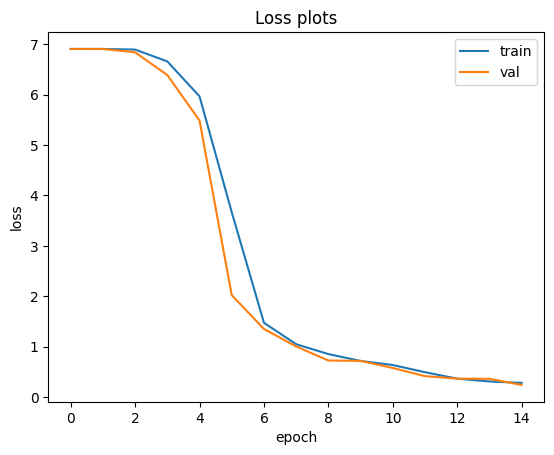

In [24]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss plots')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()
plt.savefig('loss.jpg')

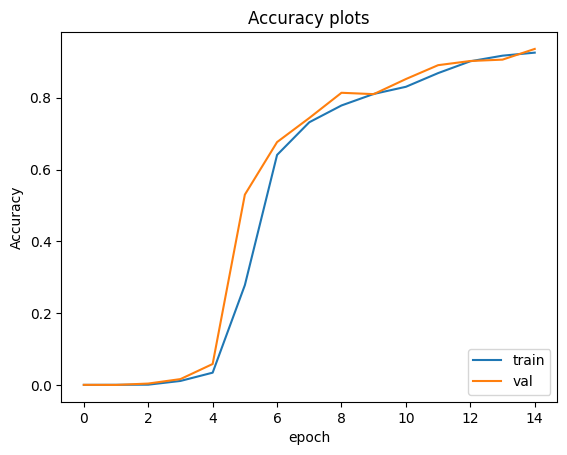

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('Accuracy plots')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.show()
plt.savefig('accuracy.jpg')

# Downstream classification training

In [12]:
#for downstream classification
import argparse
import os

import torch
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, utils, models
torch.manual_seed(3)


def visualize(sample_data_loader):

    def imshow(img, mean=0.0, std=1.0):
        """
        Parameters passed:
        img: Image to display
        mean: Mean that was subtracted while normalizing the images
        std: Standard deviation that was used for division while normalizing the image
        """
        img = img * std + mean  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    dataiter = iter(sample_data_loader)
    images, labels = dataiter.__next__()
    imshow(utils.make_grid(images))


if __name__ == '__main__':

   
    Cbatch_size = 32
    Cepochs = 20
    Coptim = 'adam'
    Clr = 1e-4
    Cweight_decay = 5e-4
    Cjigsaw_task_weights = 'resnet_jigsaw_solver_e1_js_trained.pt'
    Cmodel_file_name = 'resnet_trained_for_classification.pt'
    Cexperiment_name = 'e1_last_b'
    Ctrain_imagenet_based = False
    Ctrain_ssl_block_4_ft = True
    Ctrain_ssl_block_3_ft = False
    Ctrain_ssl_full_ft = False
    Ctrain_wo_ssl = False
    
    # Set device to use to gpu if available and declare model_file_path
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #par_weights_dir = 'weights/'
    jigsaw_pre_trained_weights_path =  Cjigsaw_task_weights

    # Data loading and data generators set up
    train_image_ids, test_image_ids, train_file_paths, test_file_paths, train_labels, test_labels = \
        get_train_test_file_paths_n_labels()

    # Get validation files and validation labels separate
    train_image_ids, val_image_ids, train_file_paths, val_file_paths, train_labels, val_labels = \
        split_train_into_train_val(train_image_ids, train_file_paths, train_labels, test_size=0.1)

    # Compute channel means
    channel_means = np.array([124.09, 127.67, 110.50]) / 256.0

    # Define data loaders
    batch_size = Cbatch_size
    train_data_loader = DataLoader(
        ConcatDataset(
            [GetDataset(train_file_paths, train_labels, def_data_transform),
             GetDataset(train_file_paths, train_labels, hflip_data_transform),
             GetDataset(train_file_paths, train_labels, darkness_jitter_transform),
             GetDataset(train_file_paths, train_labels, lightness_jitter_transform),
             GetDataset(train_file_paths, train_labels, rotations_transform),
             GetDataset(train_file_paths, train_labels, all_in_transform)]
        ),
        batch_size = batch_size, shuffle = True, num_workers = 8
    )
    val_data_gen = GetDataset(val_file_paths, val_labels, def_data_transform)
    val_data_loader = DataLoader(
        val_data_gen, batch_size=batch_size, shuffle=True, num_workers=8
    )
    test_data_gen = GetDataset(test_file_paths, test_labels, def_data_transform)
    test_data_loader = DataLoader(
        test_data_gen, batch_size=batch_size, shuffle=True, num_workers=8
    )

    # Visualize a batch of images
    # visualize(train_data_loader)

    # Train required model defined above on CUB200 data
    num_classes = 5
    epochs = Cepochs
    lr = Clr
    weight_decay_const = Cweight_decay

    if Ctrain_imagenet_based:
        model_to_train = models.resnet18(pretrained=True)
        model_to_train.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        model_to_train.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, 5),
            nn.LogSoftmax()
        )
        model_file_path = 'resnet_imagenet_based.pt'

    elif Ctrain_wo_ssl:
        model_to_train = resnet18(num_classes=num_classes, siamese_deg=None)
        model_file_path = 'resnet_trained_from_scratch.pt'

    else:
        model_to_train = resnet18(num_classes=num_classes, siamese_deg=None)
        model_to_train.fc = nn.Linear(2048 * 9, 10)  # 2048 is the last resnet layer output length which gets
        # multiplied with degree of siamese net, which for jigsaw puzzle solving was 9

        checkpoint = torch.load(jigsaw_pre_trained_weights_path)
        # print(checkpoint.keys())
        
        new_checkpoint = {}

        # Iterate through the keys in the loaded checkpoint
        for key, value in checkpoint.items():
            # Modify the key to match the existing model's module name
            new_key = key.replace('module.', '')  # Remove 'module.' prefix if it exists
            new_checkpoint[new_key] = value

        model_to_train.load_state_dict(new_checkpoint)

        # Load state dict for pre trained model weights
        # model_to_train.load_state_dict(torch.load(jigsaw_pre_trained_weights_path))

        # Redefine the last linear layer
        model_to_train.fc = nn.Linear(2048, 10)
        
        print('Model loaded successfully')

        if Ctrain_ssl_block_4_ft:
            model_file_path = 'resnet_trained_ssl_{}_last_a_ft.pt'.format(Cexperiment_name)
            for name, param in model_to_train.named_parameters():
                if name[:6] == 'layer4' or name in ['fc.0.weight', 'fc.0.bias']:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        elif Ctrain_ssl_block_3_ft:
            model_file_path = 'resnet_trained_ssl_{}_last_b_ft.pt'.format(Cexperiment_name)
            for name, param in model_to_train.named_parameters():
                if name[:6] == 'layer4' or name[:6] == 'layer3' or name in ['fc.0.weight', 'fc.0.bias']:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        else:
            model_to_train.fc = nn.Linear(2048, 5)
            model_file_path = 'resnet_trained_ssl_{}_full_ft.pt'.format(Cexperiment_name)


    # Set device on which training is done. Plus optimizer to use.
    model_to_train.to(device)
    sgd_optimizer = optim.SGD(model_to_train.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay_const)
    adam_optimizer = optim.Adam(model_to_train.parameters(), lr=lr, weight_decay=weight_decay_const)

    if Coptim == 'sgd':
        optimizer = sgd_optimizer
    else:
        optimizer = adam_optimizer

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, min_lr=1e-5)

    # Start training
    model_train_test_obj = ModelTrainTest(model_to_train, device, model_file_path)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    print('Training started')
    for epoch_no in range(epochs):
        train_loss, train_acc, val_loss, val_acc = model_train_test_obj.train(
            optimizer, epoch_no, params_max_norm=4,
            train_data_loader=train_data_loader, val_data_loader=val_data_loader
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        scheduler.step(val_loss)

    observations_df = pd.DataFrame()
    observations_df['epoch count'] = [i for i in range(1, Cepochs + 1)]
    observations_df['train loss'] = train_losses
    observations_df['val loss'] = val_losses
    observations_df['train acc'] = train_accs
    observations_df['val acc'] = val_accs
    observations_file_path = Cexperiment_name + '_observations.csv'
    observations_df.to_csv(observations_file_path)


Length of train files list 4242
Length of train labels list 4242
Length of test files list 1414
Length of test labels list 1414
Length of train files list 3817
Length of train labels 3817
Length of val files list 425
Length of val labels 425


RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([1000, 18432]) from checkpoint, the shape in current model is torch.Size([10, 18432]).
	size mismatch for fc.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([10]).

# Plot loss and accuracy curves

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss plots')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()
plt.savefig('e1_last_b_classification_loss.jpg')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('Accuracy plots')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()
plt.savefig('e1_last_b_classification_acc.jpg')

# Show confusion matrix

In [ ]:
import argparse
import os

import numpy as np
import pandas as pd

import torch
from PIL import Image
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torch import nn
from torchvision import models
from torch.autograd import Variable


def pil_loader(path):
    pil_img = Image.open(path)
    if pil_img.mode == "L":
        return None
    else:
        return pil_img


if __name__ == '__main__':

    
    Cmodel_name = 'resnet_trained_ssl_e1_last_b_last_b_ft.pt'
    Ctest_compact_bilinear = True
    Ctest_imagenet_based = False
    Ctest_on = 'test'

    # Set device to use to gpu if available and declare model_file_path
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #par_weights_dir = 'weights/'
    model_file_path = Cmodel_name

    # Data loading and data generators set up
    train_image_ids, test_image_ids, train_file_paths, test_file_paths, train_labels, test_labels = \
        get_train_test_file_paths_n_labels()

    train_image_ids, val_image_ids, train_file_paths, val_file_paths, train_labels, val_labels = \
        split_train_into_train_val(train_image_ids, train_file_paths, train_labels, test_size=0.1)

    if Ctest_imagenet_based:
        model_to_train = models.resnet18(pretrained=True)
        model_to_train.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        model_to_train.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, 5),
            nn.LogSoftmax()
        )
    else:
        model_to_train = resnet18(num_classes=5, siamese_deg=None)

    # Check if saved model exists, and load if it does.
    if os.path.exists(model_file_path):
        model_to_train.load_state_dict(torch.load(model_file_path))
    model_to_train.to(device)

    # Setup on which set evaluation is to be carried out
    if Ctest_on == 'train':
        eval_file_paths, eval_labels = train_file_paths, train_labels
    elif Ctest_on == 'val':
        eval_file_paths, eval_labels = val_file_paths, val_labels
    else:
        eval_file_paths, eval_labels = test_file_paths, test_labels

    # Start evaluation
    model_to_train.eval()
    correct = 0
    preds = []
    for f, label in zip(eval_file_paths, eval_labels):
        pil_img = pil_loader(f)
        if pil_img is None:
            preds.append(0)
            continue
        data = def_data_transform(pil_img)
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data = Variable(data, volatile=True).to(device)
        output = model_to_train(data)
        pred = output.data.max(1, keepdim=True)[1]

        x = pred.data #prediction
        preds.append(x)

        if x == label:
            correct += 1

    print (correct, len(eval_file_paths), correct * 100 / len(eval_file_paths))
    preds = np.array(preds).astype(np.float64)
    conf_mat = np.array(confusion_matrix(preds, eval_labels))
    conf_df = pd.DataFrame(conf_mat)
    conf_df.columns = np.arange(0,5)
    conf_df.to_csv('confusion_matrix.csv')